TOC

- [Run Stan](#Run-Stan-model)
- [Post process](#Post-process)
    - [HMC](#HMC)
    - [Pair plots](#Pair-plots)
    - [Phase spaces](#Phase-spaces)
    - [PPC sEEG](#PPC-sEEG)

In [1]:
%pylab inline
# comment on lofi screen
%config InlineBackend.figure_format = 'retina'
import lib
lib.cmdstan_path('~/cmdstan-2.17.0');

Populating the interactive namespace from numpy and matplotlib


## Run Stan model

Compile first,

In [2]:
lib.compile_model('vep-fe-rev-05.stan')

--- Translating Stan model to C++ code ---
bin/stanc  /Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.stan --o=/Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.hpp
Model name=vep_fe_rev_05_model
Input file=/Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.stan
Output file=/Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.hpp

--- Linking C++ model ---
clang++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -I src -I stan/src -isystem stan/lib/stan_math/ -DEIGEN_NO_DEBUG -DFUSION_MAX_VECTOR_SIZE=12 -stdlib=libc++ -Wno-unknown-warning-option -Wno-unused-function -Wno-tautological-compare -Wsign-compare -DNO_FPRINTF_OUTPUT -pipe   -O3 -o /Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05 src/cmdstan/main.cpp -include /Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05.hpp stan/lib/stan_math/lib/cvodes_2

Run multiple chains,

In [3]:
%%bash
model=vep-fe-rev-05
rm -f ${model}.optimize.*.{out,csv}

for i in `seq 4`
do
    j=0
    while ! ./$model id=$((100*$j + $i)) \
        optimize \
        data file=data.R \
        output file=${model}.optimize.$i.csv refresh=10 \
        &> ${model}.optimize.$i.out
    do
        j=$(($j + 1))
        echo "trying again.. (j=$j)"
    done
done

Process is interrupted.


Check all optimizations OK

In [249]:
!tail -n2 *optimize*out

==> vep-fe-rev-05.optimize.1.out <==
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

==> vep-fe-rev-05.optimize.2.out <==
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

==> vep-fe-rev-05.optimize.3.out <==
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

==> vep-fe-rev-05.optimize.4.out <==
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Convert optimizations to R format

In [255]:
for i in range(1, 5):
    csv = lib.parse_csv(f'vep-fe-rev-05.optimize.{i}.csv')
    data = {k: v[0] for k, v in csv.items()}
    # bug in my rdump or stan file..
    data['x_eta'] = data['x_eta'].T
    data['z_eta'] = data['z_eta'].T
    lib.rdump(f'vep-fe-rev-05.optimize.{i}.csv.R', data)

Now run MC chains

In [21]:
!./vep-fe-rev-05 help-all

  method=<list element>
    Analysis method (Note that method= is optional)
    Valid values: sample, optimize, variational, diagnose
    Defaults to sample

    sample
      Bayesian inference with Markov Chain Monte Carlo
      Valid subarguments: num_samples, num_warmup, save_warmup, thin, adapt, algorithm

      num_samples=<int>
        Number of sampling iterations
        Valid values: 0 <= num_samples
        Defaults to 1000

      num_warmup=<int>
        Number of warmup iterations
        Valid values: 0 <= warmup
        Defaults to 1000

      save_warmup=<boolean>
        Stream warmup samples to output?
        Valid values: [0, 1]
        Defaults to 0

      thin=<int>
        Period between saved samples
        Valid values: 0 < thin
        Defaults to 1

      adapt
        Warmup Adaptation
        Valid subarguments: engaged, gamma, delta, kappa, t0, init_buffer, term_buffer, window

        engaged=<boolean>
          Adaptation engaged?
          Valid values:

In [42]:
%%bash
model=vep-fe-rev-05
rm -f ${model}.sample.*.{out,csv}
for i in `seq 2`
do
    ./$model id=$i\
        sample save_warmup=1 num_warmup=200 num_samples=200 \
            adapt \
                delta=0.99 \
            algorithm=hmc \
                engine=nuts \
                    max_depth=16 \
        data file=data.R \
        output file=${model}.sample.$i.csv refresh=1 \
        &> ${model}.sample.$i.out &
done

Check status..

In [58]:
!tail -n 1 vep-fe-rev-05.sample.*.out
csv = lib.parse_csv('vep-fe-rev-05.sample.*.csv', merge=False)

==> vep-fe-rev-05.sample.1.out <==
Iteration:  21 / 400 [  5%]  (Warmup)

==> vep-fe-rev-05.sample.2.out <==
Iteration:  20 / 400 [  5%]  (Warmup)


Maybe stop them if required..

In [60]:
!killall vep-fe-rev-05

## Post process

_Often I'm running next version of model while analyzing previous version, so it's helpful to note git hash_

In [273]:
!git rev-parse HEAD

010bc9b9f27e644a465ecfd7ea244a91d9a1f2a4


### HMC

Plot HMC stats (while running)

/Users/maedoc/miniconda3/envs/scipy/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


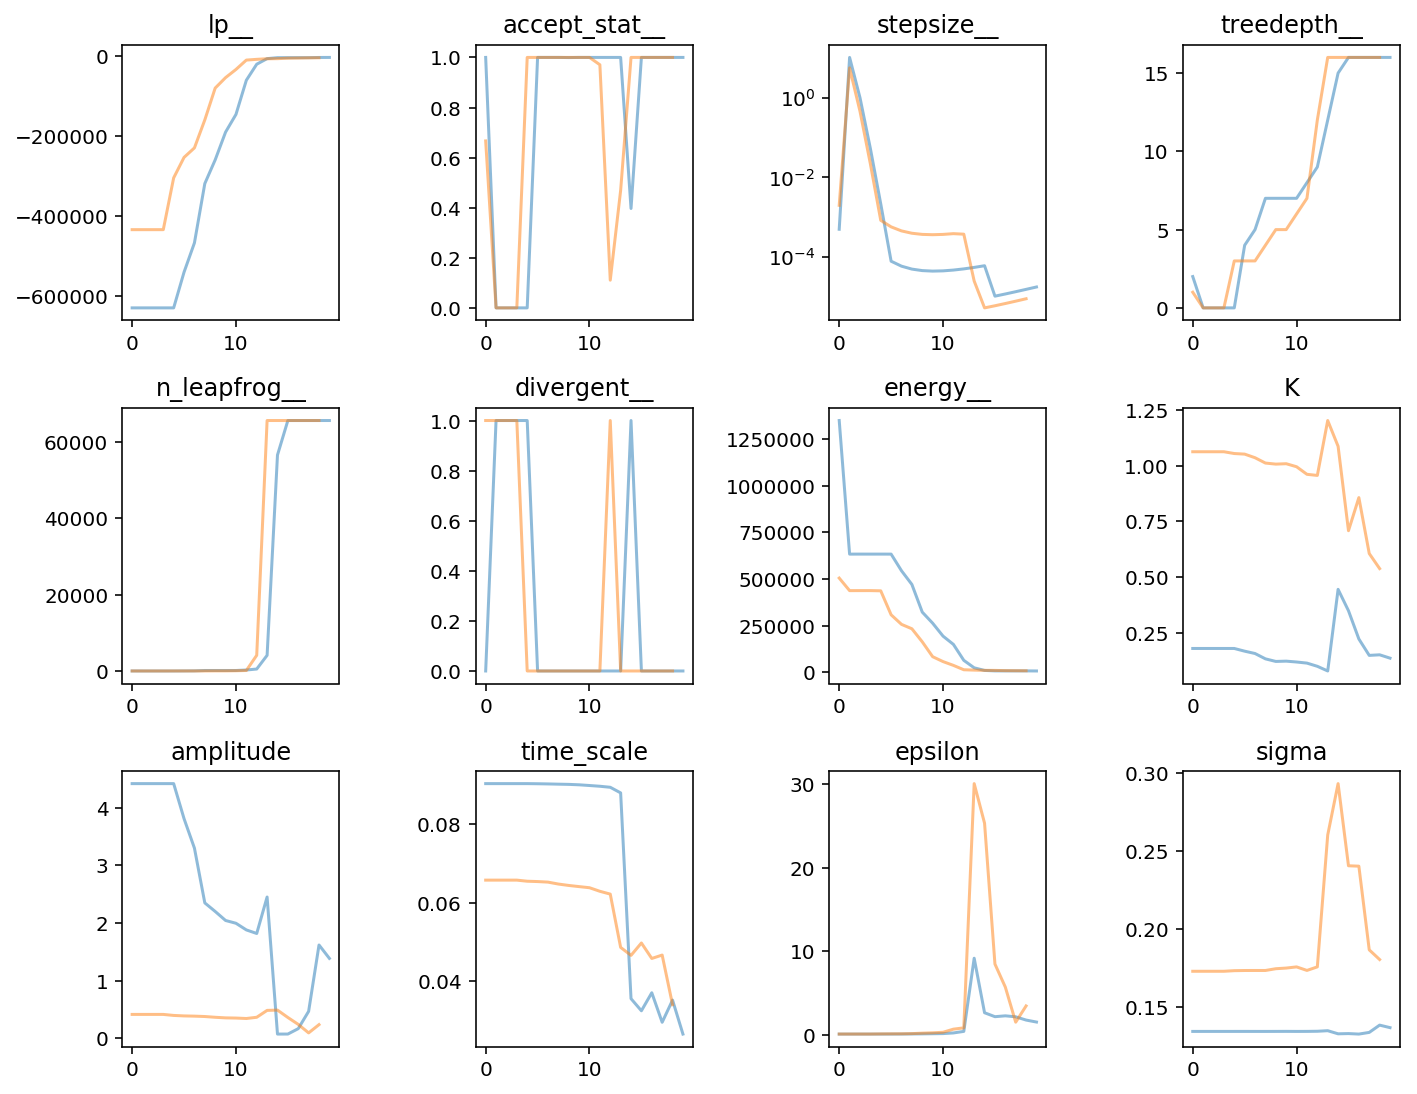

In [59]:
figure(figsize=(10, 10))
skip = 0
extras = 'K time_scale sigma epsilon amplitude'.split()
for csvi in csv:
    i = 1
    for key in csvi.keys():
        if key[-2:] == '__' or key in extras:
            subplot(4, 4, i)
            plot(csvi[key][skip:], alpha=0.5)
            if key in ('stepsize__', ):
                gca().set_yscale('log')
            title(key)
            i += 1
tight_layout()

### Pair plots

_Skip 150 warmup samples, plot different chains by color_

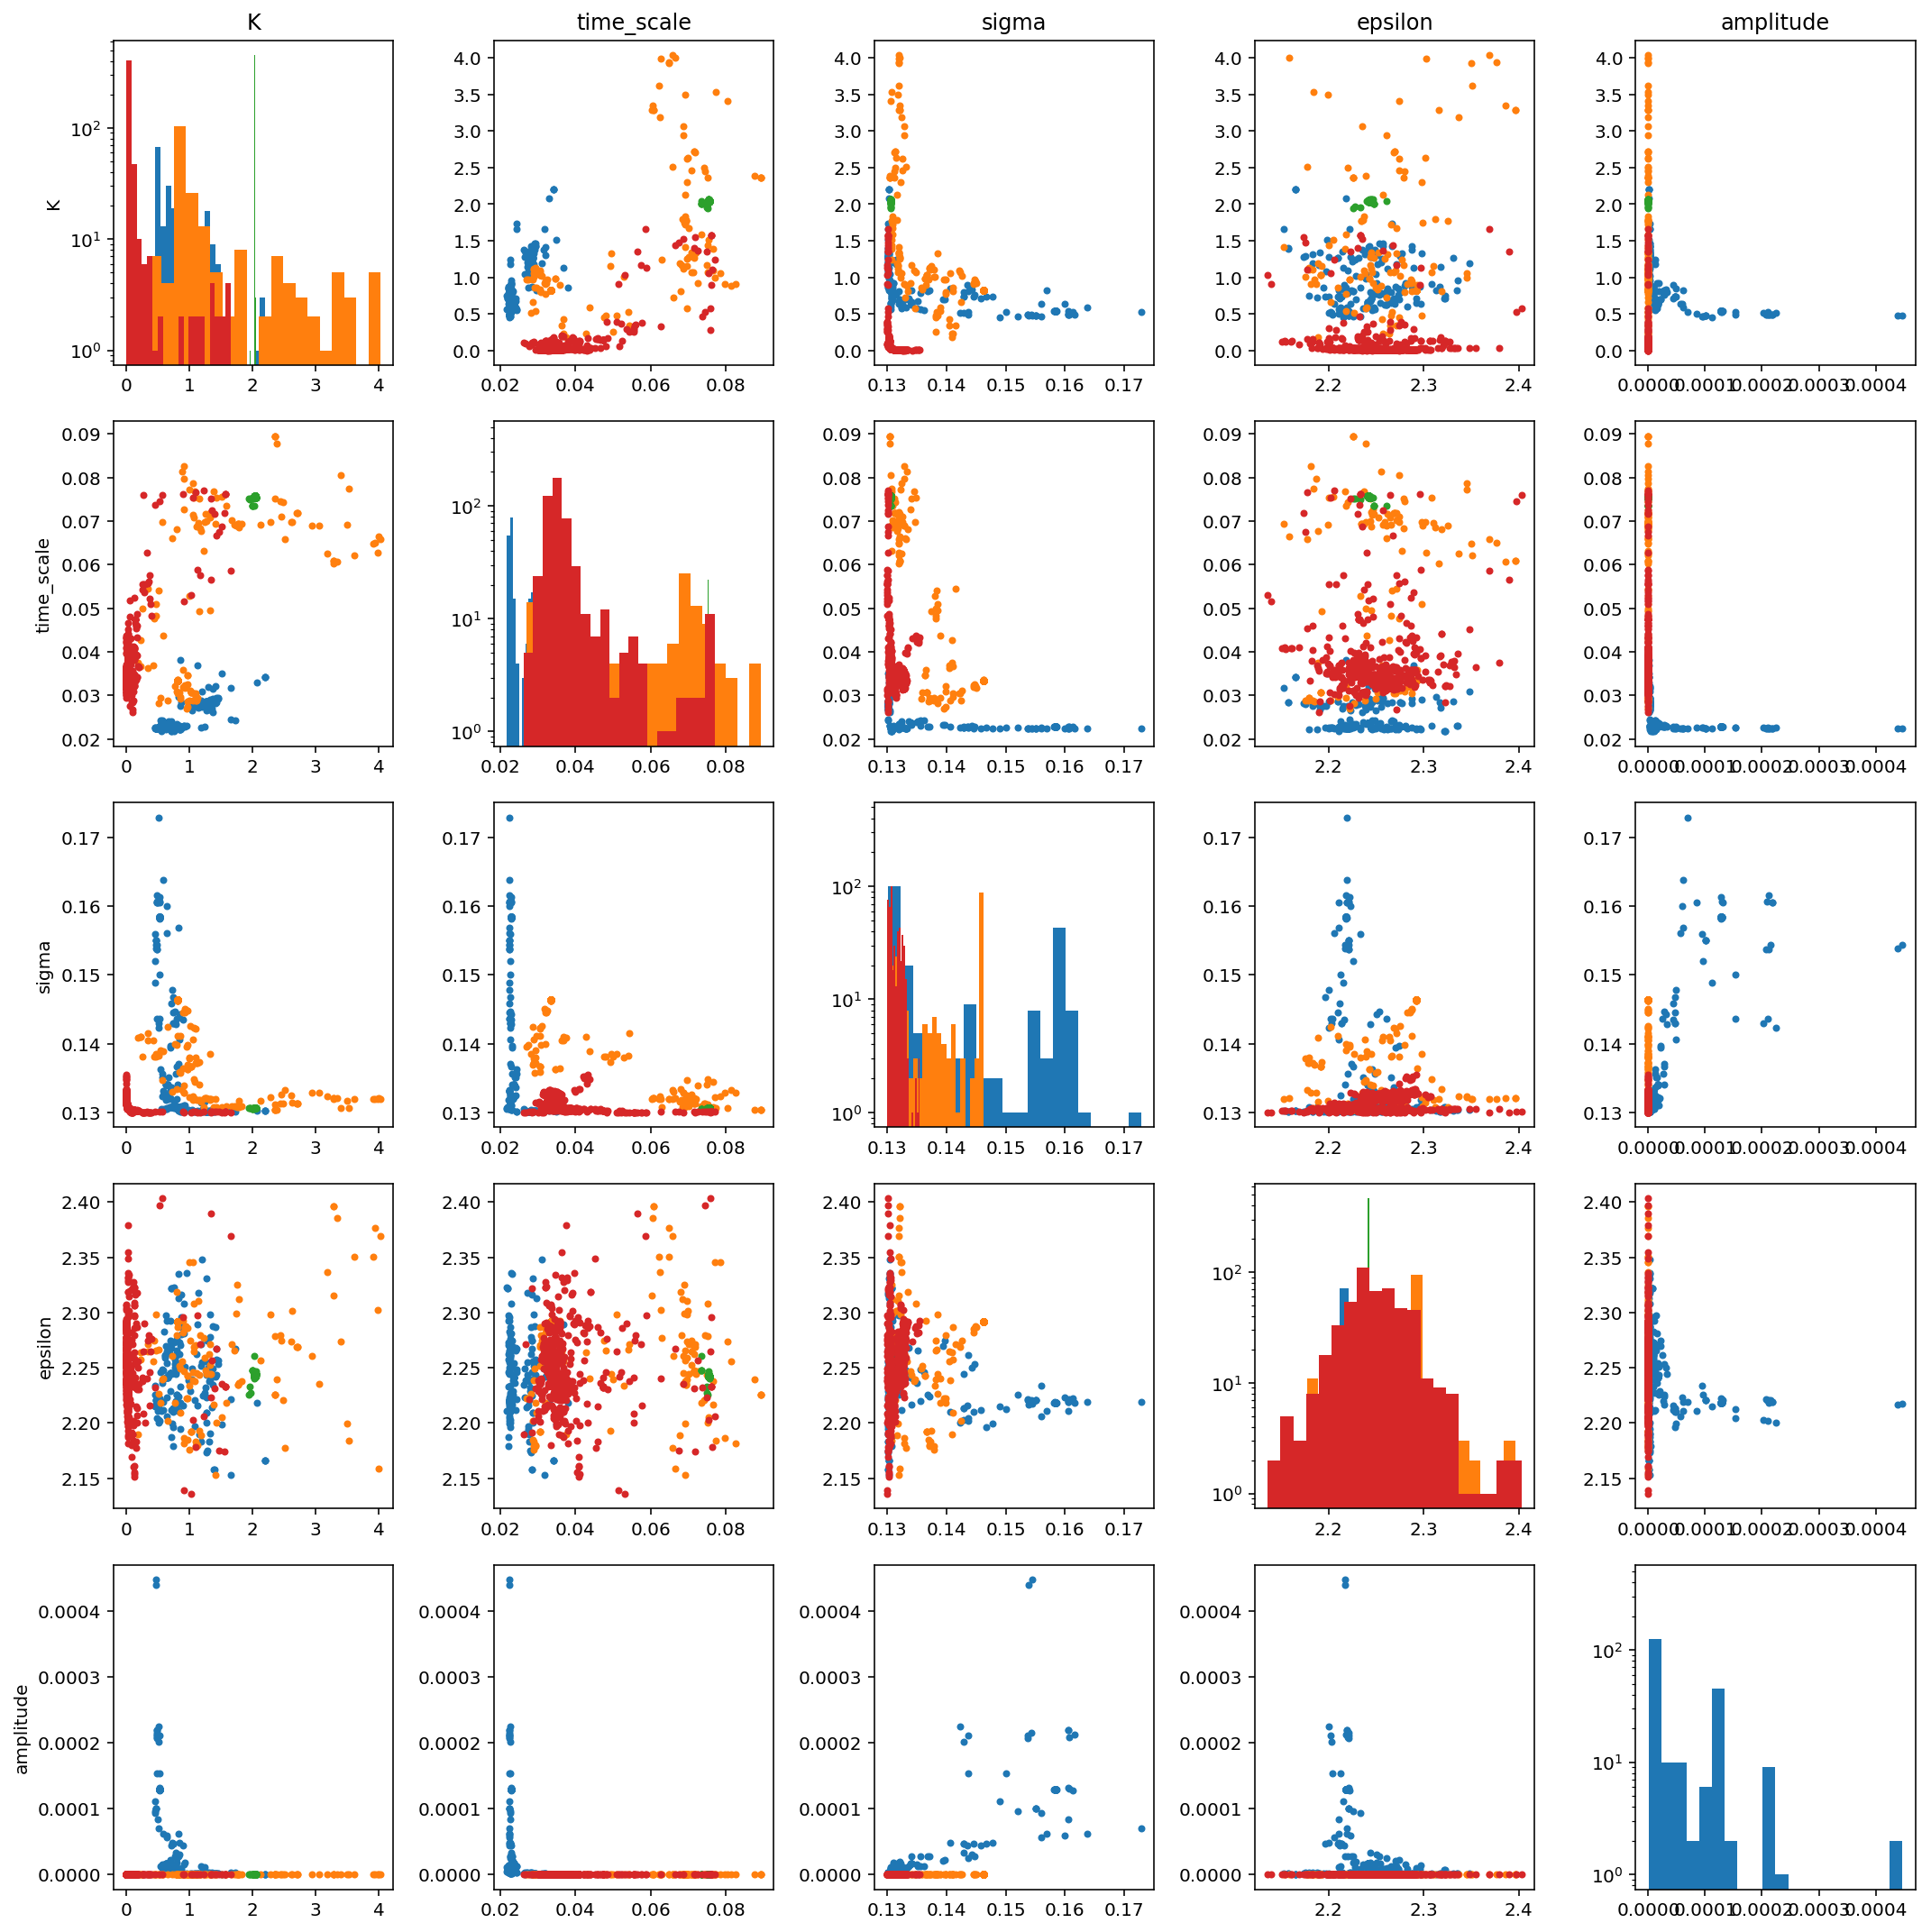

In [278]:
figure(figsize=(15, 15))
lib.reload()
lib.viz_pair_plots(csv, extras, skip=0)

There seem to be some correlations there, a SVD should tell us something..

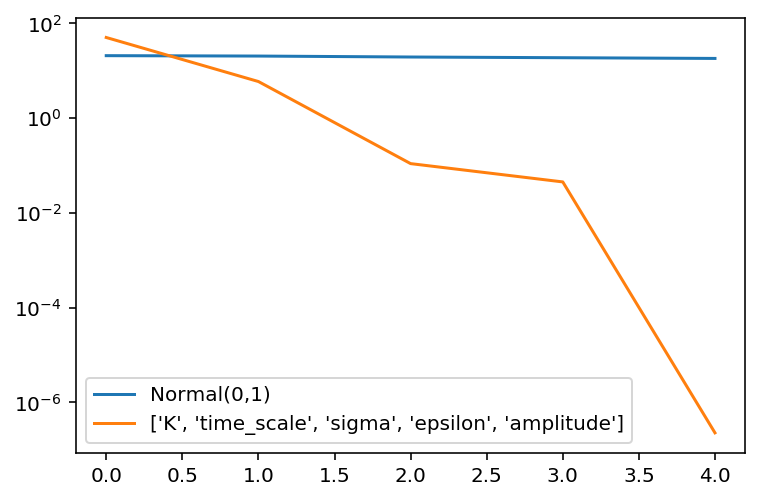

In [279]:
pars = np.array([csvi[k] for k in extras])
pars0 = randn(*pars.shape)*pars.std()
_, s0, _ = svd(pars0)
_, s1, _ = svd(pars, 0)

semilogy(s0, label='Normal(0,1)')
semilogy(s1, label=extras)
legend()

### Phase spaces

Phase space plots tell about the linear/nonlinear behavior of the neural mass model.  Specifically, the model predicts transition between healthy and seizure states when `x` passes from negative knee to positive knee.

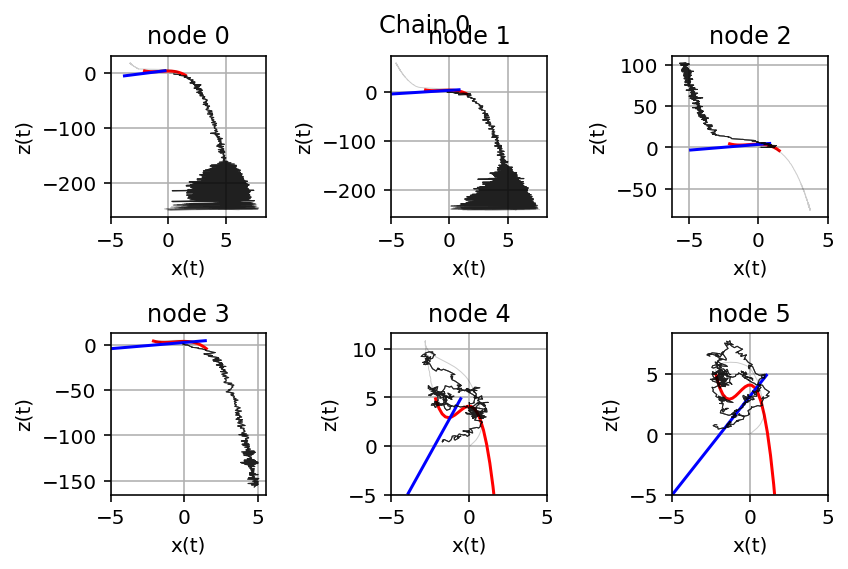

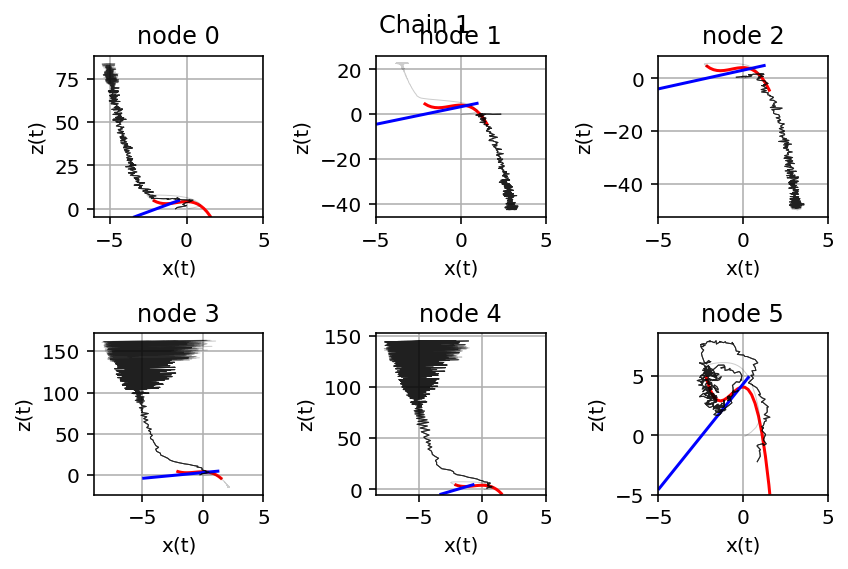

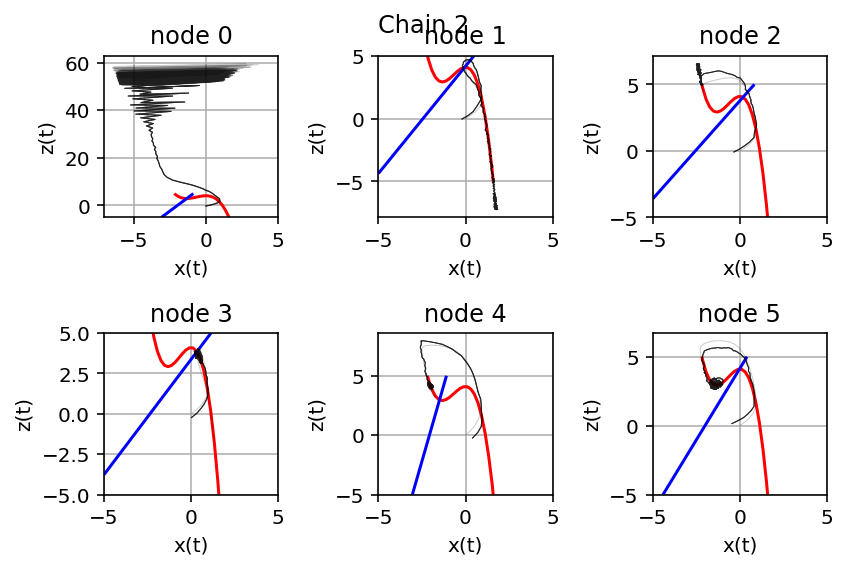

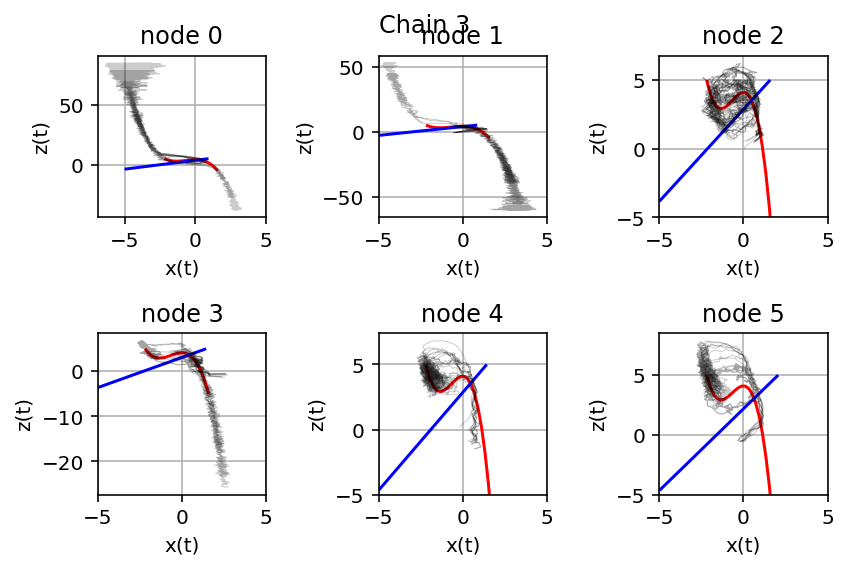

In [280]:
lib.reload()
for i, csvi in enumerate(csv):
    figure()
    lib.viz_phase_space(csvi)
    suptitle(f'Chain {i}')
    tight_layout()

Some chains running into instability.

### PPC sEEG

In [1]:
x = csv[3]['x'][:, :]
gain = np.load('data.R.npz')['gain']
x.shape, gain.shape

NameError: name 'csv' is not defined

In [282]:
yh0, yh1 = gain.dot(x)
y0, y1 = np.load('data.R.npz')['seeg_log_power'].T

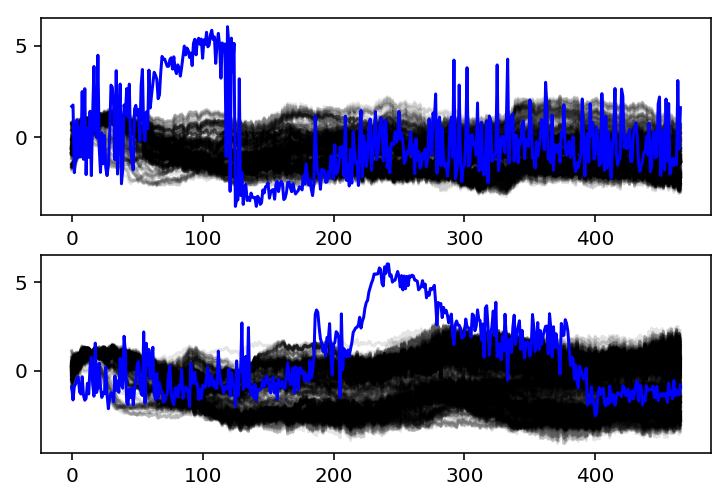

In [283]:
subplot(211)
plot(yh0.T, 'k', alpha=0.1);
plot(y0.T, 'b')

subplot(212)
plot(yh1.T, 'k', alpha=0.1);
plot(y1.T, 'b')

But this is pretty much unsatisfactory.   Issue is with `epsilon` being estimated at too high a value, to consider the model meaningful.

__rerun this after rdump transpose regen data.R! data look like shit!__